## Computation Tools for Data Science - Group 6

**Group members:**
- Raquel Chaves Martinez - s243297
- Paula Gambus i Moreno - s233219
- Angel Paisan Garcia - s232793
- Alba Pi Mas - s243280

### Library importation

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import functions as f

import string
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


## Building and exploring the dataset

**NOTE:** The result of the merge of the datasets and calculation of the sentiment can be found in *main_complete.csv*. We recommend not rerunning the code used to generating the file because the computations involved are highly resource-intensive, resulting in long execution times.

First, we open all the datasets that we are going to get information from.

In [2]:
netflix = pd.read_csv('data/netflix.csv')
amazon = pd.read_csv('data/amazon.csv')
hulu = pd.read_csv('data/hulu.csv')
apple = pd.read_csv('data/apple.csv')
hbo = pd.read_csv('data/hbo.csv')

main = pd.read_csv('data/TMDB_all_movies.csv')

Since we only want to do movie recommendation, we remove all the entries that are not classified as movies in the platform datasets.

In [3]:
print('Before removing shows')
print(netflix.shape)
print(amazon.shape)
print(hulu.shape)
print(apple.shape)
print(hbo.shape)

netflix = f.remove_tv_show(netflix)
apple = f.remove_tv_show(apple)
hulu = f.remove_tv_show(hulu)
amazon = f.remove_tv_show(amazon)
hbo = f.remove_tv_show(hbo)

#dimension of the dataset
print('After removing shows')
print(netflix.shape)
print(amazon.shape)
print(hulu.shape)
print(apple.shape)
print(hbo.shape)

Before removing shows
(20106, 8)
(66905, 8)
(9753, 8)
(17648, 8)
(7017, 8)
After removing shows
(15499, 8)
(58559, 8)
(5915, 8)
(13598, 8)
(3653, 8)


Once we have the auxiliar datasets clean, we can merge it with the main dataset. To do it, we have built a function that can be found in *function.py* . This function takes the platform dataset and the main dataset and adds a new binary column where the 0 indicates that the movie is not in the platform and the 1 represents that the movie is in the platform.

In [4]:
main_netflix = f.platform_column(main, netflix, 'Netflix')
main_net_ama = f.platform_column(main_netflix, amazon, 'Amazon')
main_net_ama_hulu = f.platform_column(main_net_ama, hulu, 'Hulu')
main_net_ama_hulu_apple = f.platform_column(main_net_ama_hulu, apple, 'Apple')
main_complete = f.platform_column(main_net_ama_hulu_apple, hbo, 'HBO')


To see the amount of movies that we have in each platform:

In [5]:
netflix_count = f.count_movies(main_complete, 'Netflix')
print('Movies in Netflix:', netflix_count)
amazon_count = f.count_movies(main_complete, 'Amazon')
print('Movies in Amazon prime:', amazon_count)
hulu_count = f.count_movies(main_complete, 'Hulu')
print('Movies in Hulu:', hulu_count)
apple_count = f.count_movies(main_complete, 'Apple')
print('Movies in Apple TV:', apple_count)
hbo_count = f.count_movies(main_complete, 'HBO')
print('Movies in HBO Max:', hbo_count)

Movies in Netflix: 36998.0
Movies in Amazon prime: 108669.0
Movies in Hulu: 15330.0
Movies in Apple TV: 32572.0
Movies in HBO Max: 10606.0


Once we have all the information in the same dataframe, we can start applying methods. First, we will calculate the sentiment of the overview of the movies.

## Calculation of the sentiment

First, we will do some exploration of the overview.

In [7]:
main_complete['overview']

0          After the coal mine he works at closes and his...
1          Nikander, a rubbish collector and would-be ent...
2          It's Ted the Bellhop's first night on the job....
3          Four young friends, while taking a shortcut en...
4          Timo Novotny labels his new project an experim...
                                 ...                        
1009834    “Hommage à Beksinski” is a short film commissi...
1009835                                                  NaN
1009836                                                  NaN
1009837                                                  NaN
1009838                                                  NaN
Name: overview, Length: 1009839, dtype: object

As it can be seen, there are some missing values in the overview (description of the movie). When we calculate the sentiment, the movies that don't have an overview will be assigned Nan and not 0, because a sentiment of 0 denotes sadness (the lower the score, the sadder is the description/movie).

We have built a sentiment function that takes a list of tokens and calculates the sentiment based on the LabMT wordlist. This function is called by a fucntion named *preprocess_and_analyze_sentiment*, which takes the text and returns the sentiment score.

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

In [9]:
main_complete['sentiment'] = main_complete['overview'].apply(f.preprocess_and_analyze_sentiment)

In [ ]:
#save the main_complete dataset
#main_complete.to_csv('data/main_complete.csv', index=False)

## Exploration of the dataset to calculate similarity

After merging the movies dataset with the platforms dataset and adding the sentiment score columnd we saved the resulting dataset ('main_complete') to avoid generating it every time. Here, we load the dataset and continue working.

In [11]:
main_complete = pd.read_csv('data/main_complete.csv')
main_complete.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,music_composer,imdb_rating,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,NaN,7.4,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,NaN,7.5,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Combustible Edison,6.7,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,Alan Silvestri,6.6,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,NaN,8.2,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44


To calculate the similarity, we need to do minhashing, that is why, a tokenization is first needed. We wanted to take several features for calculating the jaccard similarity:
- genre
- cast
- crew
- sentiment
- platforms (one-hot encoded)
- crew
- production companies
- production countries
- imbd votes
- imbd rating

To tokenize the features, we created sets for each of them with all the strings of each category inside

### Genres

In [12]:
# check how many movies have no genre
nulls = main_complete['genres'].isnull().sum()
print("This percentage of movies have no genre:", nulls/len(main_complete)*100, "%")

This percentage of movies have no genre: 29.076318106153554 %


In [13]:
# split the genres into a set of genres and remove spaces
main_complete['genres'] = main_complete['genres'].apply(lambda x: set(genre.strip() for genre in x.split(',')) if pd.notnull(x) else set())

We will also do a small analysis of the genres to learn more about the data

There are  19 different genres in the dataset
The genres are: {'Family', 'Horror', 'Music', 'Animation', 'Documentary', 'Mystery', 'Drama', 'Action', 'Western', 'Crime', 'Romance', 'Science Fiction', 'War', 'Adventure', 'Thriller', 'History', 'Comedy', 'TV Movie', 'Fantasy'}


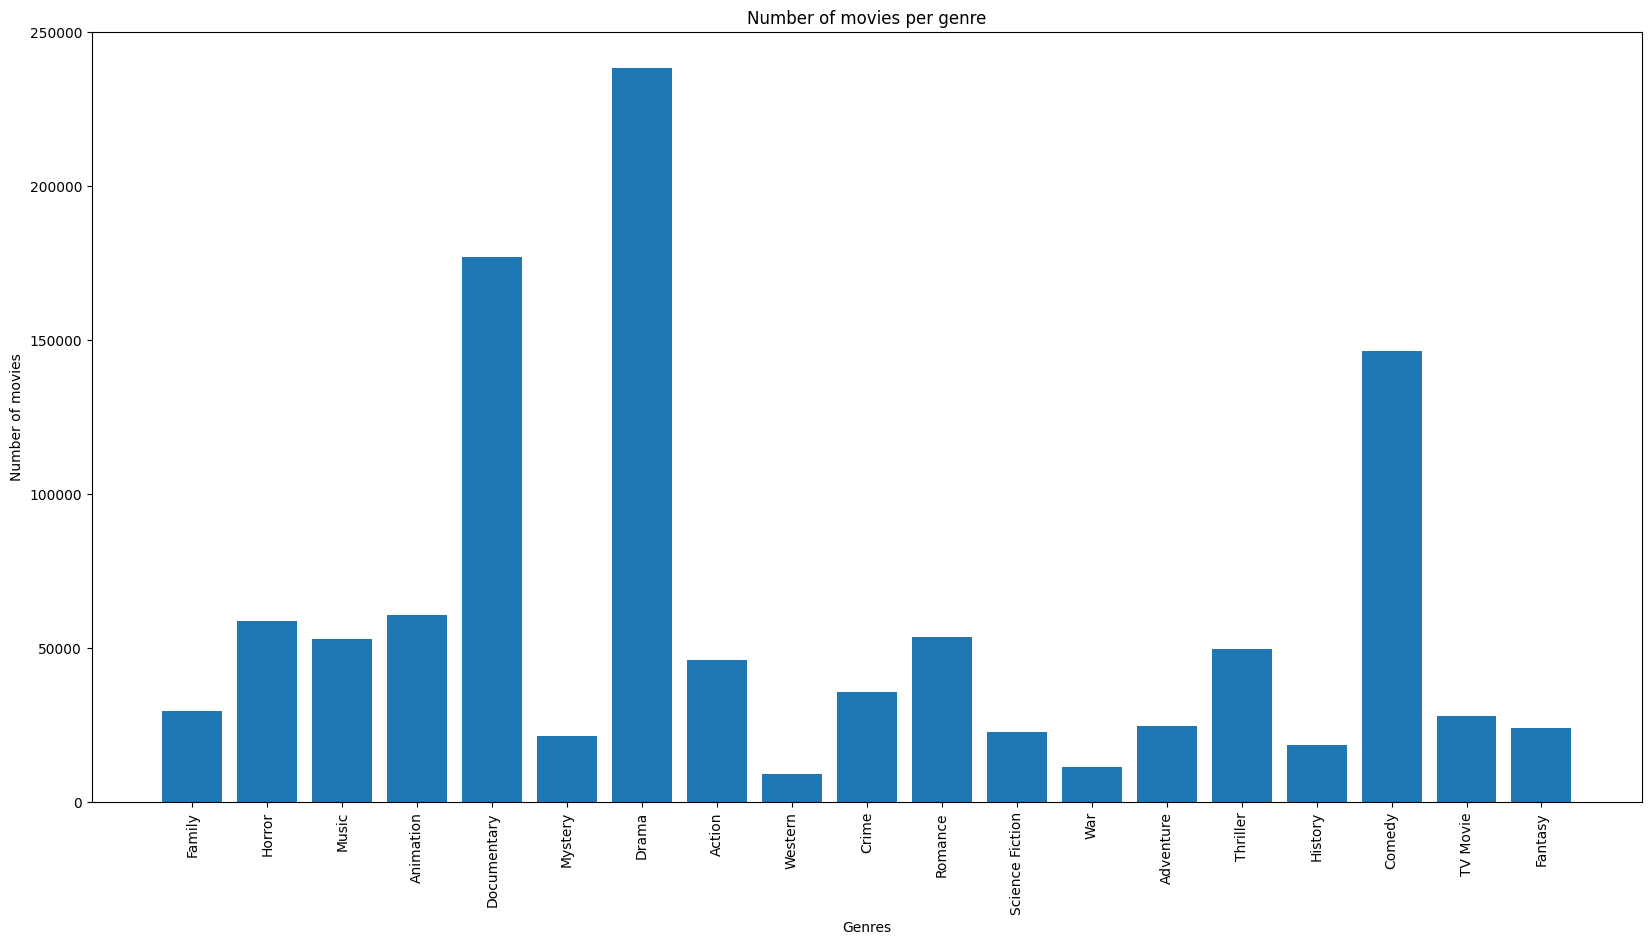

In [14]:
# check how many different genres are taking into account the content of the lists
genres = set()
for list in main_complete['genres']:
    # if list is not NaN
    if list is not np.nan:
        for genre in list:
            # remove the space at the beginning of the string if there is one
            genre = genre.strip()
            genres.add(genre)
print("There are ", len(genres), "different genres in the dataset")
print("The genres are:", genres)

genres_count = {genre: 0 for genre in genres}
for genre_list in main_complete['genres']:
    if genre_list is not np.nan:
        for genre in genre_list:
            genre = genre.strip()
            genres_count[genre] += 1

# histogram
plt.figure(figsize=(20, 10))
plt.bar(genres_count.keys(), genres_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.show()

### Cast and crew

We will know follow the same procedure with the cast and the crew. Moreover, for the crew we will join the columns of director and producers.

#### Cast

In [15]:
# split the cast into a set of cast and remove spaces
main_complete['cast'] = main_complete['cast'].apply(lambda x: set(actor.strip() for actor in x.split(',')) if pd.notnull(x) else set())

In [16]:
# how many movies have no cast
nulls = main_complete['cast'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no cast:", nulls/len(main_complete)*100, "%")

print(nulls)

This percentage of movies have no cast: 33.29124741666741 %
336188


**NOTE:** After doing several tests with the code using different features, we decided to discard the 'cast'. We took this decision based on its length, since it is usally long it has a big weight when calculating the similarities.

In [ ]:
# remove the cast column
main_complete = main_complete.drop(columns=['cast'])

#### Crew

In [17]:
# Join the director and producers columns into a single column crew
columns_to_merge = ['director', 'producers']

for column in columns_to_merge:
    main_complete[column] = main_complete[column].apply(lambda x: set(person.strip() for person in x.split(',')) if pd.notnull(x) else set())

main_complete['crew'] = main_complete.apply(lambda row: set.union(row['director'], row['producers']), axis=1)

# Drop the individual columns
main_complete.drop(columns=columns_to_merge, inplace=True)

In [18]:
# how many movies have no crew
nulls = main_complete['crew'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no crew:", nulls/len(main_complete)*100, "%")

This percentage of movies have no crew: 17.2818637426362 %


### Production companies and countries

The same procedure was also followed with these two features

In [19]:
# split the production_companies into a set and remove spaces
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: set(company.strip() for company in x.split(',')) if pd.notnull(x) else set())
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: x - {''})


In [20]:
# percentage of movies with no production companies
nulls = main_complete['production_companies'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production companies:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production companies: 53.91235632610743 %


In [21]:
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: set(country.strip() for country in x.split(',')) if pd.notnull(x) else set())
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: x - {''})

In [22]:
# percentage of movies with no production countries
nulls = main_complete['production_countries'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production countries:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production countries: 39.518774774988884 %


### Sentiment

To take into account the sentiment of the movie description, we decided to create three categories depending on the values.

To find the thresholds we calculated the mean and the standard deviation of the sentiment and we classified those further away from the mean than the standard deviation on the low end as low, those within the standard deviation as medium and those further away from the mean than the standard deviation on the high end as high. 

In [23]:
sentiment_min = main_complete['sentiment'].min()
sentiment_max = main_complete['sentiment'].max()
sentiment_mean = main_complete['sentiment'].mean()
sentiment_std = main_complete['sentiment'].std()
sentiment_mid = main_complete['sentiment'].median()

print(f"Range of sentiment values: {sentiment_min} to {sentiment_max} with mean {sentiment_mean} and standard deviation {sentiment_std} and median {sentiment_mid}")

Range of sentiment values: 0.0 to 621.52 with mean 109.39746533773106 and standard deviation 83.97651422418457 and median 85.76


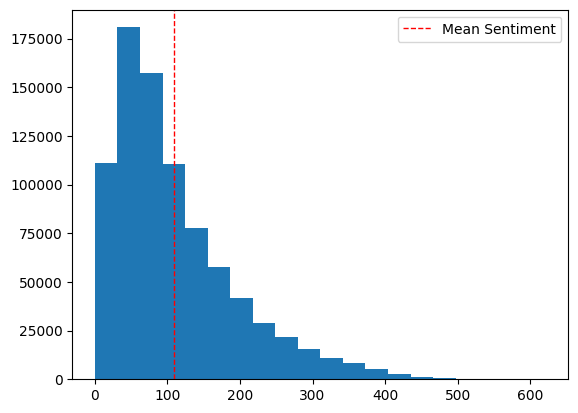

In [24]:
plt.hist(main_complete['sentiment'], bins=20)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.legend()
plt.show()

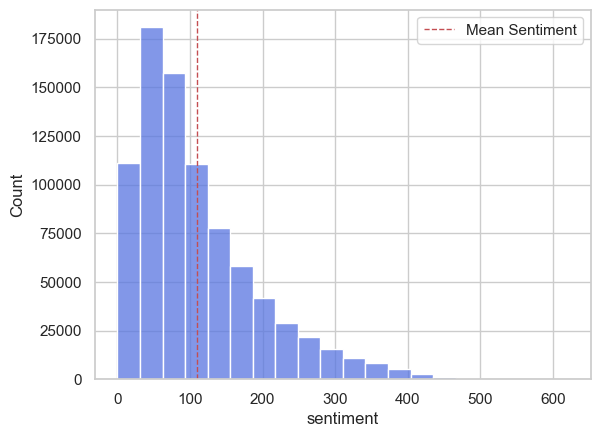

In [32]:
sns.set_theme(style="whitegrid")

sns.histplot(data=main_complete, x='sentiment', bins=20, color='#5875E1', kde=False)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.legend()
plt.show()

In [33]:
# Define the thresholds for sentiment ranges
low_threshold = sentiment_mean - sentiment_std
high_threshold = sentiment_mean + sentiment_std

# Function to categorize sentiment
def categorize_sentiment(value):
    if value < low_threshold:
        return 'low'
    elif value > high_threshold:
        return 'high'
    else:
        return 'medium'

# Assuming main_complete is already defined and categorize_sentiment is a function
main_complete.loc[:, 'sentiment_category'] = main_complete['sentiment'].apply(categorize_sentiment)

# Display the updated dataframe
main_complete[['title', 'sentiment', 'sentiment_category']].head()

,title,sentiment,sentiment_category
0,Ariel,68.24,medium
1,Shadows in Paradise,73.44,medium
2,Four Rooms,86.06,medium
3,Judgment Night,79.34,medium
4,Life in Loops (A Megacities RMX),382.44,high


### Dataset cleaning

Before doing the minhashing, we will remove the movies that were not 'Released' or have more than four of the features that we are interested in empty.

In [34]:
# clean movies with 4 or more interesting columns empty
columns = ['genres', 'crew', 'production_companies', 'production_countries', 'sentiment_category']

initial_count = len(main_complete)

# check each row if they have 3 or more columns from columns with empty sets
main_complete = main_complete[~(main_complete[columns].apply(lambda x: sum(1 for i in x if len(i) == 0) >= 4, axis=1))]
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  94569 from a total of  1009839
Percentage of movies removed:  9.364760125128857 %


In [35]:
# remove movies if the 'status' is not 'Released'
initial_count = len(main_complete)
main_complete = main_complete[main_complete['status'] == 'Released']
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  15995 from a total of  915270
Percentage of movies removed:  1.7475717547827416 %
